In [1]:
import matplotlib.pyplot as plt
from torch.fft import fft2, ifft2, fftshift, rfft2, irfft2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np
import time

import matplotlib.pyplot as plt

from scattering_transform.scattering_transform import *
from scattering_transform.filters import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Train the subnet so it starts off as a morlet

86.82606506347656
10.485170364379883
1.5471792221069336
0.6208400726318359
0.38675570487976074


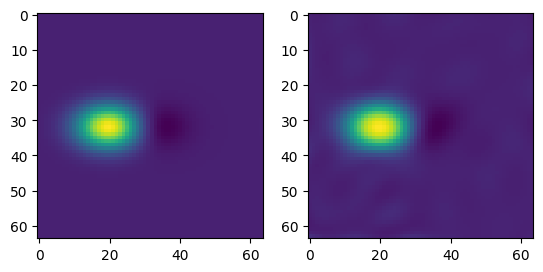

In [3]:
class Sine(nn.Module):
    def __init__(self):
        super(Sine, self).__init__()
        self.omega = nn.Parameter(torch.rand(1))

    def forward(self, x):
        return torch.sin(self.omega * x)

size = 64
morl = fftshift(Morlet(size, 6, 6).filter_tensor[1, 5])
morl_flat = morl.flatten(0, 1)[:, None]
xyspace = torch.linspace(-1, 1, size)
grid = torch.stack(torch.meshgrid(xyspace, xyspace)).flatten(1, 2).swapaxes(0, 1)

morlet_subnet = SubNet(hidden_sizes=(8, 8), activation=Sine)

optimiser = optim.Adam(morlet_subnet.parameters(), lr=1e-3)

for e in range(5000):
    loss = ((morlet_subnet(grid) - morl_flat)**2).sum()
    loss.backward()
    optimiser.step()
    optimiser.zero_grad() 
    if e % 1000 == 0:
        print(loss.item())

outs = morlet_subnet(grid).detach().reshape(size, size)

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(morl)
axes[1].imshow(outs)
plt.show()

In [4]:
class GeneralDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]
    

class MLP(nn.Module):
    def __init__(self, ins, hiddens, outs):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Linear(ins, hiddens),
            nn.LeakyReLU(), 
            nn.Linear(hiddens, hiddens),
            nn.LeakyReLU(),
            nn.Linear(hiddens, outs))
        
    def forward(self, x):
        return self.seq(x)

### MNIST Classifier

In [31]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def rand_roll(x):
    roll_x = torch.randint(x.shape[-1], (1,)).item()
    roll_y = torch.randint(x.shape[-1], (1,)).item()
    return x.roll(shifts=(roll_x, roll_y), dims=(-1, -2))


# Define the transformation for the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=360),
    transforms.Lambda(lambda x: rand_roll(x)),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.squeeze(0)),
])

# Download and load the training set
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Create a train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Download and load the validation set
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create a validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# Define the training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100.0 * correct / total

    return train_loss, train_acc

# Define the validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze()
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100.0 * correct / total

    return val_loss, val_acc

In [32]:
for a, b in train_dataloader:
    print(a.shape, b.dtype)
    break

torch.Size([512, 28, 28]) torch.int64


In [ ]:
class OSTAC(nn.Module):
    def __init__(self):
        super().__init__()
        self.wv = FourierSubNetFilters(28, 3, 6, subnet=SubNet(hidden_sizes=(3, 3)))
        self.st = ScatteringTransform2d(self.wv)
        self.st.to(device)
        self.bn = nn.BatchNorm1d(127)
        self.mlp = MLP(127, 32, 10)

    def forward(self, x):
        self.wv.update_filters()
        self.st.clip_filters()
        x = reduce_coefficients(*self.st.scattering_transform(x), 
                                reduction=None,) 
                                #normalise_s1=True,
                                #normalise_s2=True)
        x = self.bn(x)
        x = self.mlp(x)
        return nn.functional.softmax(x, dim=1)

# Create the model instance
model = OSTAC()
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of training epochs
num_epochs = 200

# Training loop
val_acc_ost_relu = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_dataloader, criterion, device)
    val_acc_ost_relu.append(val_acc)
    
    print(f'Epoch [{epoch}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

Epoch [1/200], Train Loss: 2.2312, Train Accuracy: 20.02%, Val Loss: 2.3220, Val Accuracy: 13.01%
Epoch [2/200], Train Loss: 2.1277, Train Accuracy: 31.75%, Val Loss: 2.0642, Val Accuracy: 39.80%
Epoch [3/200], Train Loss: 2.0357, Train Accuracy: 42.26%, Val Loss: 2.0174, Val Accuracy: 44.12%
Epoch [4/200], Train Loss: 2.0132, Train Accuracy: 44.54%, Val Loss: 2.0917, Val Accuracy: 35.89%
Epoch [5/200], Train Loss: 1.9979, Train Accuracy: 46.04%, Val Loss: 1.9916, Val Accuracy: 46.72%
Epoch [6/200], Train Loss: 1.9876, Train Accuracy: 46.99%, Val Loss: 1.9826, Val Accuracy: 47.63%
Epoch [7/200], Train Loss: 1.9788, Train Accuracy: 48.02%, Val Loss: 1.9830, Val Accuracy: 47.80%
Epoch [8/200], Train Loss: 1.9754, Train Accuracy: 48.36%, Val Loss: 1.9782, Val Accuracy: 48.16%
Epoch [9/200], Train Loss: 1.9696, Train Accuracy: 48.94%, Val Loss: 1.9756, Val Accuracy: 48.41%
Epoch [10/200], Train Loss: 1.9660, Train Accuracy: 49.25%, Val Loss: 1.9813, Val Accuracy: 47.63%
Epoch [11/200], Tra

Epoch [84/200], Train Loss: 1.6082, Train Accuracy: 85.55%, Val Loss: 1.6065, Val Accuracy: 85.86%
Epoch [85/200], Train Loss: 1.6077, Train Accuracy: 85.69%, Val Loss: 1.6076, Val Accuracy: 85.67%
Epoch [86/200], Train Loss: 1.6059, Train Accuracy: 85.78%, Val Loss: 1.5997, Val Accuracy: 86.56%
Epoch [87/200], Train Loss: 1.6042, Train Accuracy: 86.02%, Val Loss: 1.5999, Val Accuracy: 86.40%
Epoch [88/200], Train Loss: 1.6036, Train Accuracy: 86.05%, Val Loss: 1.5976, Val Accuracy: 86.59%
Epoch [89/200], Train Loss: 1.6027, Train Accuracy: 86.16%, Val Loss: 1.5950, Val Accuracy: 86.80%
Epoch [90/200], Train Loss: 1.6024, Train Accuracy: 86.20%, Val Loss: 1.6014, Val Accuracy: 86.35%
Epoch [91/200], Train Loss: 1.6019, Train Accuracy: 86.06%, Val Loss: 1.5983, Val Accuracy: 86.49%
Epoch [92/200], Train Loss: 1.6006, Train Accuracy: 86.23%, Val Loss: 1.6034, Val Accuracy: 85.91%
Epoch [93/200], Train Loss: 1.6001, Train Accuracy: 86.38%, Val Loss: 1.6026, Val Accuracy: 86.31%
Epoch [94/

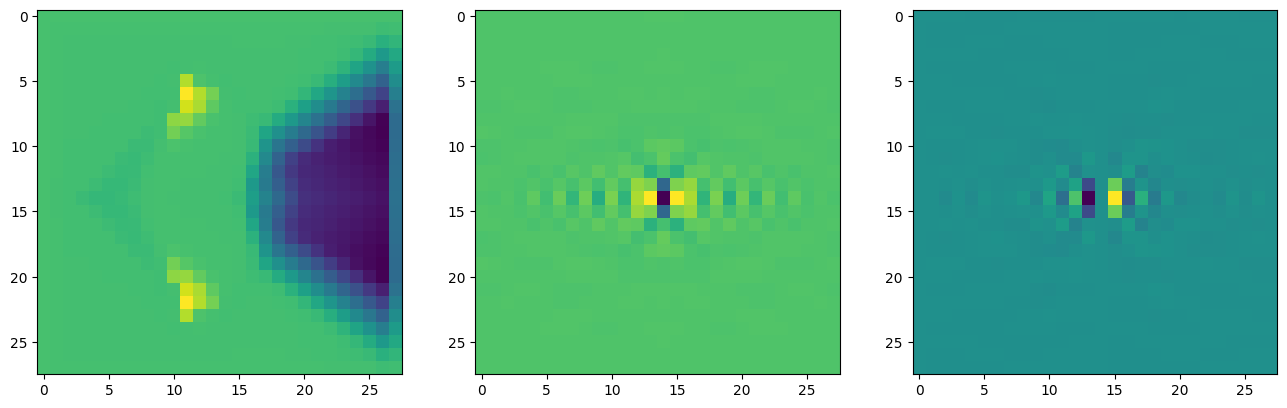

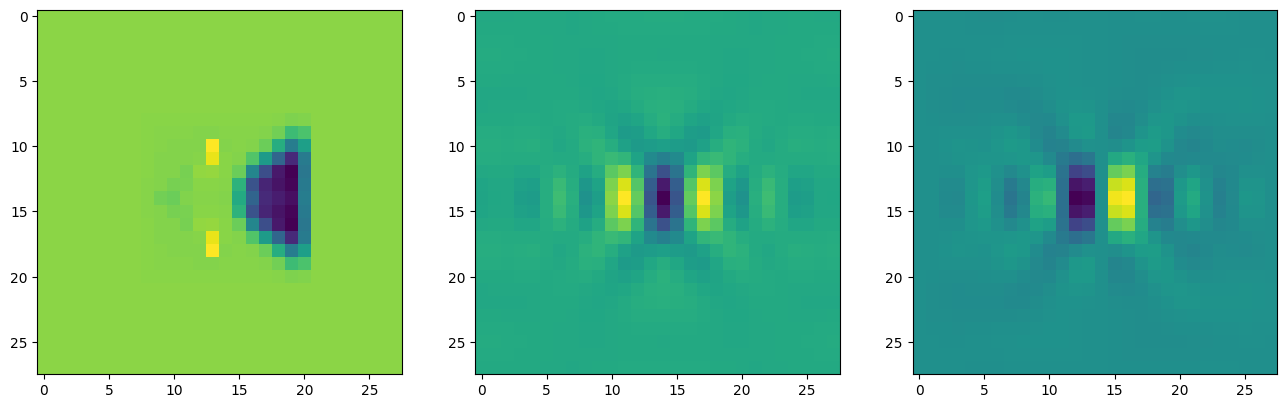

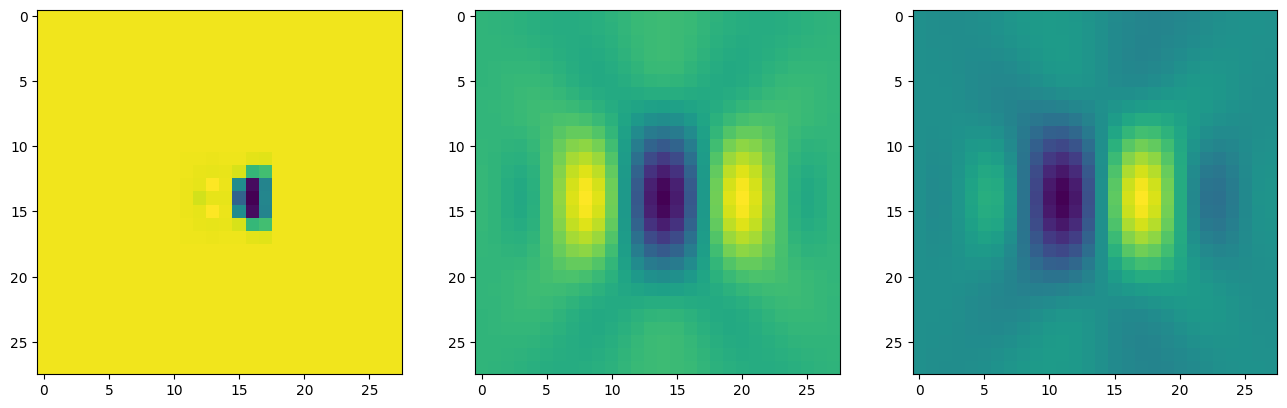

In [8]:
ft = model.wv.filter_tensor.cpu().detach()

for i in range(model.wv.num_scales):
    fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
    k = ft[i, 0]
    x = torch.fft.fftshift(torch.fft.fft2(k))
    axes[0].imshow(torch.fft.fftshift(k))
    axes[1].imshow(x.real)
    axes[2].imshow(x.imag)
    plt.show()


#### Baseline compare

In [26]:
class STAC(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn = nn.BatchNorm1d(127)
        self.mlp = MLP(127, 32, 10)

    def forward(self, x):
        x = self.bn(x)
        x = self.mlp(x)
        return nn.functional.softmax(x, dim=1)
    
def batch_apply(data, bs, func, device):
    results = []
    num_batches = data.shape[0] // bs
    num_batches = num_batches if data.shape[0] % bs == 0 else num_batches + 1
    for i in range(num_batches):
        x = data[bs*i:bs*(i+1)]
        x = x.to(device)
        results.append(func(x))
    return torch.cat(results, dim=0)

class GeneralDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]
    


wv = Morlet(28, 3, 6)
st = ScatteringTransform2d(wv) 
st.to(device)

def st_func(x):
    return reduce_coefficients(*st.scattering_transform(x), reduction=None)

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_data = batch_apply(train_dataset.data.float(), 64, st_func, device).cpu()
val_data = batch_apply(val_dataset.data.float(), 64, st_func, device).cpu()

train_dataset = GeneralDataset(train_data, train_dataset.targets)
val_dataset = GeneralDataset(val_data, val_dataset.targets)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [27]:
model_vanilla = STAC()
model_vanilla.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vanilla.parameters(), lr=0.001)

# Set the number of training epochs
num_epochs = 200

# Training loop
val_accs_vanilla = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model_vanilla, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = validate(model_vanilla, val_dataloader, criterion, device)
    val_accs_vanilla.append(val_acc)

    print(f'Epoch [{epoch}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

Epoch [1/200], Train Loss: 2.0671, Train Accuracy: 43.08%, Val Loss: 1.8451, Val Accuracy: 68.09%
Epoch [2/200], Train Loss: 1.7261, Train Accuracy: 76.63%, Val Loss: 1.6458, Val Accuracy: 84.24%
Epoch [3/200], Train Loss: 1.6175, Train Accuracy: 86.53%, Val Loss: 1.5849, Val Accuracy: 89.46%
Epoch [4/200], Train Loss: 1.5786, Train Accuracy: 89.64%, Val Loss: 1.5618, Val Accuracy: 91.23%
Epoch [5/200], Train Loss: 1.5613, Train Accuracy: 91.03%, Val Loss: 1.5503, Val Accuracy: 92.14%
Epoch [6/200], Train Loss: 1.5512, Train Accuracy: 91.84%, Val Loss: 1.5435, Val Accuracy: 92.62%
Epoch [7/200], Train Loss: 1.5446, Train Accuracy: 92.42%, Val Loss: 1.5392, Val Accuracy: 92.79%
Epoch [8/200], Train Loss: 1.5392, Train Accuracy: 92.88%, Val Loss: 1.5349, Val Accuracy: 93.16%
Epoch [9/200], Train Loss: 1.5353, Train Accuracy: 93.19%, Val Loss: 1.5337, Val Accuracy: 93.12%
Epoch [10/200], Train Loss: 1.5327, Train Accuracy: 93.45%, Val Loss: 1.5304, Val Accuracy: 93.48%
Epoch [11/200], Tra

Epoch [84/200], Train Loss: 1.4962, Train Accuracy: 96.63%, Val Loss: 1.5065, Val Accuracy: 95.60%
Epoch [85/200], Train Loss: 1.4960, Train Accuracy: 96.61%, Val Loss: 1.5091, Val Accuracy: 95.32%
Epoch [86/200], Train Loss: 1.4964, Train Accuracy: 96.66%, Val Loss: 1.5080, Val Accuracy: 95.40%
Epoch [87/200], Train Loss: 1.4965, Train Accuracy: 96.58%, Val Loss: 1.5077, Val Accuracy: 95.41%
Epoch [88/200], Train Loss: 1.4956, Train Accuracy: 96.72%, Val Loss: 1.5067, Val Accuracy: 95.63%
Epoch [89/200], Train Loss: 1.4957, Train Accuracy: 96.70%, Val Loss: 1.5079, Val Accuracy: 95.39%
Epoch [90/200], Train Loss: 1.4962, Train Accuracy: 96.64%, Val Loss: 1.5076, Val Accuracy: 95.50%
Epoch [91/200], Train Loss: 1.4956, Train Accuracy: 96.67%, Val Loss: 1.5074, Val Accuracy: 95.42%
Epoch [92/200], Train Loss: 1.4960, Train Accuracy: 96.66%, Val Loss: 1.5076, Val Accuracy: 95.46%
Epoch [93/200], Train Loss: 1.4953, Train Accuracy: 96.70%, Val Loss: 1.5069, Val Accuracy: 95.59%
Epoch [94/

Epoch [167/200], Train Loss: 1.4895, Train Accuracy: 97.26%, Val Loss: 1.5066, Val Accuracy: 95.46%
Epoch [168/200], Train Loss: 1.4898, Train Accuracy: 97.23%, Val Loss: 1.5062, Val Accuracy: 95.60%
Epoch [169/200], Train Loss: 1.4902, Train Accuracy: 97.17%, Val Loss: 1.5061, Val Accuracy: 95.58%
Epoch [170/200], Train Loss: 1.4900, Train Accuracy: 97.21%, Val Loss: 1.5048, Val Accuracy: 95.73%
Epoch [171/200], Train Loss: 1.4893, Train Accuracy: 97.25%, Val Loss: 1.5045, Val Accuracy: 95.67%
Epoch [172/200], Train Loss: 1.4890, Train Accuracy: 97.28%, Val Loss: 1.5037, Val Accuracy: 95.81%
Epoch [173/200], Train Loss: 1.4896, Train Accuracy: 97.22%, Val Loss: 1.5050, Val Accuracy: 95.56%
Epoch [174/200], Train Loss: 1.4887, Train Accuracy: 97.33%, Val Loss: 1.5049, Val Accuracy: 95.67%
Epoch [175/200], Train Loss: 1.4883, Train Accuracy: 97.35%, Val Loss: 1.5054, Val Accuracy: 95.63%
Epoch [176/200], Train Loss: 1.4895, Train Accuracy: 97.26%, Val Loss: 1.5059, Val Accuracy: 95.57%


In [28]:
wv = FixedFilterBank(model.wv.filter_tensor)
st = ScatteringTransform2d(wv) 
st.to(device)

def st_func(x):
    return reduce_coefficients(*st.scattering_transform(x), reduction=None,)

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_data = batch_apply(train_dataset.data.float(), 64, st_func, device).cpu()
val_data = batch_apply(val_dataset.data.float(), 64, st_func, device).cpu()

train_dataset = GeneralDataset(train_data, train_dataset.targets)
val_dataset = GeneralDataset(val_data, val_dataset.targets)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [29]:
model_fixed = STAC()
model_fixed.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_fixed.parameters(), lr=0.01)

# Set the number of training epochs
num_epochs = 200

# Training loop
val_accs_fixed = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model_fixed, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = validate(model_fixed, val_dataloader, criterion, device)
    val_accs_fixed.append(val_acc)

    print(f'Epoch [{epoch}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

Epoch [1/200], Train Loss: 1.7414, Train Accuracy: 72.12%, Val Loss: 1.5691, Val Accuracy: 89.54%
Epoch [2/200], Train Loss: 1.5608, Train Accuracy: 90.20%, Val Loss: 1.5493, Val Accuracy: 91.41%
Epoch [3/200], Train Loss: 1.5481, Train Accuracy: 91.33%, Val Loss: 1.5331, Val Accuracy: 92.89%
Epoch [4/200], Train Loss: 1.5365, Train Accuracy: 92.49%, Val Loss: 1.5304, Val Accuracy: 93.13%
Epoch [5/200], Train Loss: 1.5346, Train Accuracy: 92.66%, Val Loss: 1.5272, Val Accuracy: 93.51%
Epoch [6/200], Train Loss: 1.5304, Train Accuracy: 93.05%, Val Loss: 1.5301, Val Accuracy: 93.13%
Epoch [7/200], Train Loss: 1.5313, Train Accuracy: 92.99%, Val Loss: 1.5295, Val Accuracy: 93.17%
Epoch [8/200], Train Loss: 1.5278, Train Accuracy: 93.34%, Val Loss: 1.5227, Val Accuracy: 93.82%
Epoch [9/200], Train Loss: 1.5293, Train Accuracy: 93.18%, Val Loss: 1.5211, Val Accuracy: 93.99%
Epoch [10/200], Train Loss: 1.5281, Train Accuracy: 93.26%, Val Loss: 1.5266, Val Accuracy: 93.45%
Epoch [11/200], Tra

Epoch [84/200], Train Loss: 1.5515, Train Accuracy: 90.97%, Val Loss: 1.5481, Val Accuracy: 91.29%
Epoch [85/200], Train Loss: 1.5501, Train Accuracy: 91.10%, Val Loss: 1.5408, Val Accuracy: 92.03%
Epoch [86/200], Train Loss: 1.5460, Train Accuracy: 91.55%, Val Loss: 1.5354, Val Accuracy: 92.56%
Epoch [87/200], Train Loss: 1.5901, Train Accuracy: 87.09%, Val Loss: 1.5440, Val Accuracy: 91.77%
Epoch [88/200], Train Loss: 1.5466, Train Accuracy: 91.49%, Val Loss: 1.5433, Val Accuracy: 91.72%
Epoch [89/200], Train Loss: 1.5551, Train Accuracy: 90.60%, Val Loss: 1.5435, Val Accuracy: 91.80%
Epoch [90/200], Train Loss: 1.5574, Train Accuracy: 90.37%, Val Loss: 1.5477, Val Accuracy: 91.36%
Epoch [91/200], Train Loss: 1.5456, Train Accuracy: 91.51%, Val Loss: 1.5361, Val Accuracy: 92.52%
Epoch [92/200], Train Loss: 1.5388, Train Accuracy: 92.23%, Val Loss: 1.5394, Val Accuracy: 92.24%
Epoch [93/200], Train Loss: 1.5510, Train Accuracy: 91.02%, Val Loss: 1.5383, Val Accuracy: 92.32%
Epoch [94/

KeyboardInterrupt: 

In [ ]:
plt.plot(range(1, 201), val_accs_vanilla, label='vanilla')
# plt.plot(range(1, 51), val_acc_ost, label='Pretrained+Sine')
plt.plot(range(1, 201), val_accs_fixed, label='ReLU')
plt.title('Rotation and Translation Invariant MNIST Classification with ST')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
# plt.ylim(90, 100)
plt.legend()
plt.show()

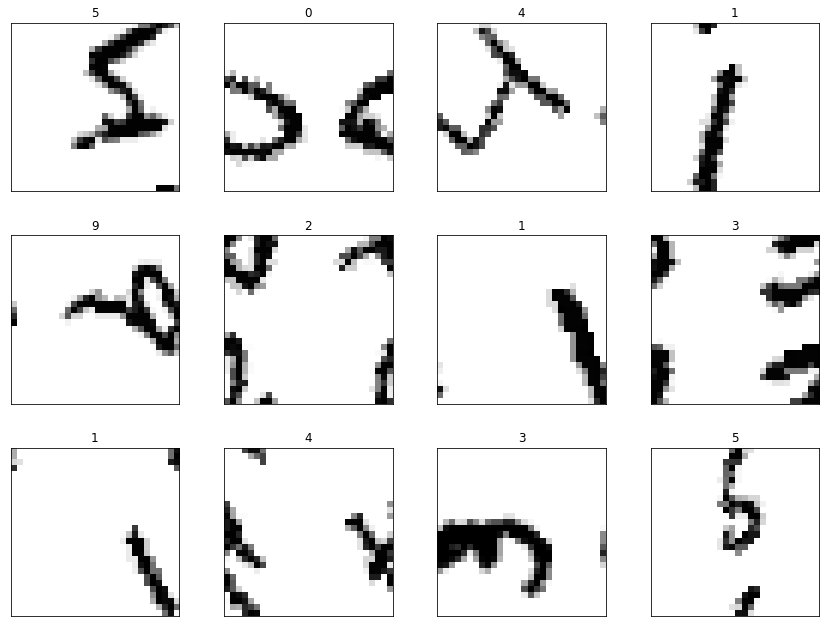

In [80]:
def show_images_grid(dataset, nrows, ncols):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
    fig.tight_layout()

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            image, label = dataset[index]
            axs[i][j].imshow(-image, cmap='gray')
            axs[i][j].set_title(f"{label}")
            axs[i][j].set_xticks([])
            axs[i][j].set_yticks([])

    plt.show()
    
show_images_grid(train_dataset, 3, 4)